<a href="https://colab.research.google.com/github/myan105/Crime-Analytics-Dashboard/blob/main/Crime-Amalytics-Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install requests beautifulsoup4 pandas tabula-py pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 828.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 817.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.1 MB/s eta 0:00:00


In [ ]:
%%shell
sudo apt-get update -y
sudo apt-get install -y openjdk-17-jre-headless

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,006 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ub

In [ ]:
import requests, time, random
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

START_URL = "https://www.longbeach.gov/police/crime-info/crime-statistics/"

def make_session():
    s = requests.Session()
    retries = Retry(
        total=6, connect=6, read=6,
        backoff_factor=1.2,                      # 0s, 1.2s, 2.4s, 3.6s...
        status_forcelist=[429,500,502,503,504],
        allowed_methods=["GET","HEAD"],
        raise_on_status=False,
    )
    s.headers.update({
        "User-Agent": "Mozilla/5.0 "
    })
    s.mount("https://", HTTPAdapter(max_retries=retries))
    s.mount("http://", HTTPAdapter(max_retries=retries))
    return s

session = make_session()

def robust_get(url, connect_timeout=20, read_timeout=60):
    # separate connect/read timeouts; many sites are slow to respond
    return session.get(url, timeout=(connect_timeout, read_timeout))

# Try again
resp = robust_get(START_URL)
print(resp.status_code)
print(resp.url[:120], "...")
print(resp.text[:400])


200
https://www.longbeach.gov/police/crime-info/crime-statistics/ ...



<!DOCTYPE html>
<html xmlns="https://www.w3.org/1999/xhtml" class="no-js" lang="en" itemscope itemtype="https://schema.org/Product">
<head>
    <title>Crime Statistics</title>
    <meta charset="utf-8" />
    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0" />
            <meta property="og:image


In [ ]:
import re
from urllib.parse import urljoin
from bs4 import BeautifulSoup

START_URL = "https://www.longbeach.gov/police/crime-info/crime-statistics/"
soup = BeautifulSoup(resp.text, "html.parser")

pdf_urls = []
for a in soup.find_all("a", href=True):
    real = urljoin(START_URL, a["href"].strip())
    if "/police/media-library/documents/crime-info/statistics/" in real.lower():
        if real.lower().endswith(".pdf") or re.search(r"/\d{4}/\d{4}[-_]\d{2}[-_].*ibr", real, re.I):
            pdf_urls.append(real)

# de-dup
pdf_urls = list(dict.fromkeys(pdf_urls))
print("Found", len(pdf_urls), "PDFs")
pdf_urls[:5]


Found 28 PDFs


['https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-01-monthly-ibr',
 'https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-02-monthly-ibr',
 'https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-03-monthly-ibr',
 'https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-04-monthly-ibr',
 'https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-05-monthly-ibr']

In [ ]:
import os, re, time, random, shutil
from pathlib import Path

# --- 1) Filter strictly to 2025 links (double-check by regex) ---
# Assumes you already have `pdf_urls` from earlier
pdf_urls_2025 = [
    u for u in pdf_urls
    if re.search(r"/crime-info/statistics/2025/", u, re.I)   # year folder is 2025
       or re.search(r"/2025[-_]\d{2}", u, re.I)              # filename like 2025-01...
]
print("Filtered to 2025:", len(pdf_urls_2025))
print(*pdf_urls_2025[:5], sep="\n")

# Optional sanity check: show which years are present in URLs
years_in_urls = sorted(set(re.findall(r"/(20\d{2})/", " ".join(pdf_urls_2025))))
print("Years detected in filtered URLs:", years_in_urls)

# --- 2) Clean target folder so no old files remain ---
PDF_DIR = Path("/content/data/pdfs_2025")
shutil.rmtree(PDF_DIR, ignore_errors=True)
PDF_DIR.mkdir(parents=True, exist_ok=True)

# --- 3) Downloader that only uses the 2025 list ---
def sanitize_filename(url: str) -> str:
    name = url.split("/")[-1] or "report.pdf"
    if not name.lower().endswith(".pdf"):
        name += ".pdf"
    return name.replace("%20","_").replace(" ", "_")

def download_pdf_2025(url: str) -> str | None:
    fn = sanitize_filename(url)
    path = PDF_DIR / fn
    r = session.get(url, timeout=(20, 120))
    r.raise_for_status()
    path.write_bytes(r.content)
    time.sleep(random.uniform(0.8, 1.6))
    return str(path)

local_pdfs_2025 = [p for p in (download_pdf_2025(u) for u in pdf_urls_2025) if p]
print(f"Saved {len(local_pdfs_2025)} PDFs → {PDF_DIR}")

# --- 4) Verify all saved files are 2025 by filename ---
only_2025 = all(re.search(r"2025", os.path.basename(p)) for p in local_pdfs_2025)
print("All filenames indicate 2025:", only_2025)
print([os.path.basename(p) for p in local_pdfs_2025][:5])


Filtered to 2025: 7
https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-01-monthly-ibr
https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-02-monthly-ibr
https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-03-monthly-ibr
https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-04-monthly-ibr
https://www.longbeach.gov/globalassets/police/media-library/documents/crime-info/statistics/2025/2025-05-monthly-ibr
Years detected in filtered URLs: ['2025']
Saved 7 PDFs → /content/data/pdfs_2025
All filenames indicate 2025: True
['2025-01-monthly-ibr.pdf', '2025-02-monthly-ibr.pdf', '2025-03-monthly-ibr.pdf', '2025-04-monthly-ibr.pdf', '2025-05-monthly-ibr.pdf']


In [ ]:
import pandas as pd, tabula, re, os
from pathlib import Path

TABLE_DIR = Path("/content/data/tables_2025")
TABLE_DIR.mkdir(parents=True, exist_ok=True)
COMBINED_2025 = "/content/data/lbpd_2025_all_tables.csv"

def infer_year_month(filename: str):
    m = re.search(r"(2025)[-_](\d{2})", filename)
    if m: return int(m.group(1)), int(m.group(2))
    return 2025, None

frames = []
for pdf_path in local_pdfs_2025:
    print("Parsing:", os.path.basename(pdf_path))
    try:
        tables = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True, guess=True)
    except Exception as e:
        print("  !! tabula error:", e)
        tables = []

    yr, mo = infer_year_month(os.path.basename(pdf_path))

    for i, df in enumerate(tables):
        if df is None or df.empty:
            continue
        df = df.replace(r"^\s*$", pd.NA, regex=True).dropna(how="all").dropna(how="all", axis=1)
        if df.empty:
            continue
        df["source_pdf"]  = os.path.basename(pdf_path)
        df["year"]        = yr
        df["month"]       = mo
        df["table_index"] = i

        out_csv = TABLE_DIR / (os.path.basename(pdf_path).replace(".pdf", f"_table{i}.csv"))
        df.to_csv(out_csv, index=False)
        frames.append(df)

if frames:
    big = pd.concat(frames, ignore_index=True)
    big.to_csv(COMBINED_2025, index=False)
    print(" Combined 2025 CSV saved:", COMBINED_2025)
else:
    print("No tables parsed for 2025.")


Parsing: 2025-01-monthly-ibr.pdf
Parsing: 2025-02-monthly-ibr.pdf
Parsing: 2025-03-monthly-ibr.pdf
Parsing: 2025-04-monthly-ibr.pdf
Parsing: 2025-05-monthly-ibr.pdf
Parsing: 2025-06-monthly-ibr.pdf
Parsing: 2025-07-monthly-ibr.pdf
 Combined 2025 CSV saved: /content/data/lbpd_2025_all_tables.csv


In [ ]:
# Check a sample table
sample = pd.read_csv(next(iter(TABLE_DIR.glob("*.csv"))))
sample.head(10)


,CRIME CATEGORYFEBRUARY 2025YTD,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,source_pdf,year,month,table_index
0,20252024#%20252024#%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-monthly-ibr.pdf,2025,2,1
1,NaN,Murder,0,1,-1.0,-100.0%,0.0,1.0,-1.0,-100.0%,2025-02-monthly-ibr.pdf,2025,2,1
2,NaN,Manslaughter,0,0,0.0,-,0.0,0.0,0.0,-,2025-02-monthly-ibr.pdf,2025,2,1
3,NaN,Rape / Sexual Assault,8,12,-4.0,-33.3%,21.0,26.0,-5.0,-19.2%,2025-02-monthly-ibr.pdf,2025,2,1
4,NaN,Aggravated Assault,46,47,-1.0,-2.1%,99.0,90.0,9.0,10.0%,2025-02-monthly-ibr.pdf,2025,2,1
5,NaN,Simple Assault,89,118,-29.0,-24.6%,230.0,240.0,-10.0,-4.2%,2025-02-monthly-ibr.pdf,2025,2,1
6,NaN,Intimidation,16,19,-3.0,-15.8%,35.0,36.0,-1.0,-2.8%,2025-02-monthly-ibr.pdf,2025,2,1
7,NaN,Human Trafficking,0,0,0.0,-,0.0,0.0,0.0,-,2025-02-monthly-ibr.pdf,2025,2,1
8,NaN,Kidnapping/Abduction,3,4,-1.0,-25.0%,5.0,8.0,-3.0,-37.5%,2025-02-monthly-ibr.pdf,2025,2,1
9,NaN,Sex Offenses (All Other),0,1,-1.0,-100.0%,0.0,1.0,-1.0,-100.0%,2025-02-monthly-ibr.pdf,2025,2,1


In [ ]:
# Clean the table
import numpy as np
import pandas as pd
import glob

def clean_crime_table(path):
    df = pd.read_csv(path)

    # Find the column with crime categories
    cat_col = None
    for col in df.columns:
        if df[col].astype(str).str.contains("Murder|Manslaughter|Rape|Assault|Burglary", case=False, na=False).any():
            cat_col = col
            break
    if cat_col is None:
        return None

    # Rename and drop junk rows
    df = df.rename(columns={cat_col: "crime_category"})
    df = df.dropna(subset=["crime_category"])
    df = df[~df["crime_category"].str.contains("CRIME|CATEGORY|TOTAL|YTD", na=False, case=False)]

    # Detect numeric columns
    num_cols = [c for c in df.columns if c not in ["crime_category","source_pdf","year","month","table_index"]]
    # Convert to numeric
    num_df = df[num_cols].apply(pd.to_numeric, errors="coerce")

    # Pick the numeric column with the most non-NaN values
    if not num_df.empty:
        best_col = num_df.count().idxmax()
        df["count"] = num_df[best_col]
    else:
        df["count"] = np.nan

    # Keep only relevant columns
    keep_cols = ["year","month","crime_category","count","source_pdf"]
    return df[keep_cols]

# Apply to all 2025 tables
all_cleaned = []
for path in glob.glob("/content/data/tables_2025/*.csv"):
    try:
        clean_df = clean_crime_table(path)
        if clean_df is not None:
            all_cleaned.append(clean_df)
    except Exception as e:
        print("Error cleaning", path, e)

if all_cleaned:
    tidy = pd.concat(all_cleaned, ignore_index=True)
    tidy.to_csv("/content/data/lbpd_2025_tidy.csv", index=False)
    print(" Fixed tidy dataset → /content/data/lbpd_2025_tidy.csv")
    display(tidy.head(20))
else:
    print(" Still no clean tables produced")


 Fixed tidy dataset → /content/data/lbpd_2025_tidy.csv


,year,month,crime_category,count,source_pdf
0,2025,2,Murder,0.0,2025-02-monthly-ibr.pdf
1,2025,2,Manslaughter,0.0,2025-02-monthly-ibr.pdf
2,2025,2,Rape / Sexual Assault,8.0,2025-02-monthly-ibr.pdf
3,2025,2,Aggravated Assault,46.0,2025-02-monthly-ibr.pdf
4,2025,2,Simple Assault,89.0,2025-02-monthly-ibr.pdf
5,2025,2,Intimidation,16.0,2025-02-monthly-ibr.pdf
6,2025,2,Human Trafficking,0.0,2025-02-monthly-ibr.pdf
7,2025,2,Kidnapping/Abduction,3.0,2025-02-monthly-ibr.pdf
8,2025,2,Sex Offenses (All Other),0.0,2025-02-monthly-ibr.pdf
9,2025,2,Robbery,NaN,2025-02-monthly-ibr.pdf


In [ ]:
# Load tidy data
tidy = pd.read_csv("/content/data/lbpd_2025_tidy.csv")

# Pivot: months as rows, crime categories as columns
pivoted = tidy.pivot_table(
    index=["year","month"],
    columns="crime_category",
    values="count",
    aggfunc="first"   # each category appears once per month
).reset_index()

# Optional: sort columns so year, month come first
cols = ["year","month"] + [c for c in pivoted.columns if c not in ["year","month"]]
pivoted = pivoted[cols]

# Save to CSV
pivoted.to_csv("/content/data/lbpd_2025_pivot.csv", index=False)
print(" Pivoted summary saved → /content/data/lbpd_2025_pivot.csv")

pivoted.head()


 Pivoted summary saved → /content/data/lbpd_2025_pivot.csv


crime_category,year,month,Aggravated Assault,Animal Cruelty,Arson,Auto Burglary,Bike Theft,Bribery,Commercial,Counterfeiting/Forgery,...,Petty Theft < $950,Pornography/Obscene Material,Prostitution,Rape / Sexual Assault,Residential,Robbery,Sex Offenses (All Other),Simple Assault,Stolen Property Offenses,Weapon Law Violations
0,2025,1,24.0,0.0,4.0,75.0,5.0,0.0,24.0,3.0,...,112.0,1.0,0.0,14.0,35.0,22.0,0.0,88.0,4.0,13.0
1,2025,2,46.0,0.0,1.0,46.0,4.0,0.0,14.0,1.0,...,85.0,0.0,0.0,8.0,26.0,NaN,0.0,89.0,2.0,14.0
2,2025,3,157.0,2.0,10.0,113.0,19.0,0.0,38.0,12.0,...,251.0,1.0,0.0,28.0,76.0,60.0,0.0,365.0,8.0,52.0
3,2025,4,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0
4,2025,5,56.0,1.0,6.0,49.0,3.0,0.0,11.0,5.0,...,86.0,0.0,0.0,12.0,30.0,14.0,0.0,133.0,6.0,19.0


In [ ]:
# Add a monthly total
import pandas as pd

pivoted = pd.read_csv("/content/data/lbpd_2025_pivot.csv")

# treat NaNs as 0 for summing
value_cols = [c for c in pivoted.columns if c not in ("year","month")]
pivoted["monthly_total"] = pivoted[value_cols].fillna(0).sum(axis=1)

# sort by month just in case
pivoted = pivoted.sort_values(["year","month"]).reset_index(drop=True)

pivoted.to_csv("/content/data/lbpd_2025_pivot.csv", index=False)  # overwrite with total included
pivoted.head()


,year,month,Aggravated Assault,Animal Cruelty,Arson,Auto Burglary,Bike Theft,Bribery,Commercial,Counterfeiting/Forgery,...,Pornography/Obscene Material,Prostitution,Rape / Sexual Assault,Residential,Robbery,Sex Offenses (All Other),Simple Assault,Stolen Property Offenses,Weapon Law Violations,monthly_total
0,2025,1,24.0,0.0,4.0,75.0,5.0,0.0,24.0,3.0,...,1.0,0.0,14.0,35.0,22.0,0.0,88.0,4.0,13.0,673.0
1,2025,2,46.0,0.0,1.0,46.0,4.0,0.0,14.0,1.0,...,0.0,0.0,8.0,26.0,NaN,0.0,89.0,2.0,14.0,554.0
2,2025,3,157.0,2.0,10.0,113.0,19.0,0.0,38.0,12.0,...,1.0,0.0,28.0,76.0,60.0,0.0,365.0,8.0,52.0,1889.0
3,2025,4,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,16.0
4,2025,5,56.0,1.0,6.0,49.0,3.0,0.0,11.0,5.0,...,0.0,0.0,12.0,30.0,14.0,0.0,133.0,6.0,19.0,715.0


In [ ]:
# Quick QA checks to make sure months are complete and counts looks numeric
print("Months present:", sorted(pivoted["month"].unique()))
print("Any nulls in monthly_total?", pivoted["monthly_total"].isna().any())
print("Top 5 months by total:")
display(pivoted.nlargest(5, "monthly_total")[["year","month","monthly_total"]])


Months present: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Any nulls in monthly_total? False
Top 5 months by total:


,year,month,monthly_total
2,2025,3,1889.0
4,2025,5,715.0
0,2025,1,673.0
1,2025,2,554.0
6,2025,7,474.0


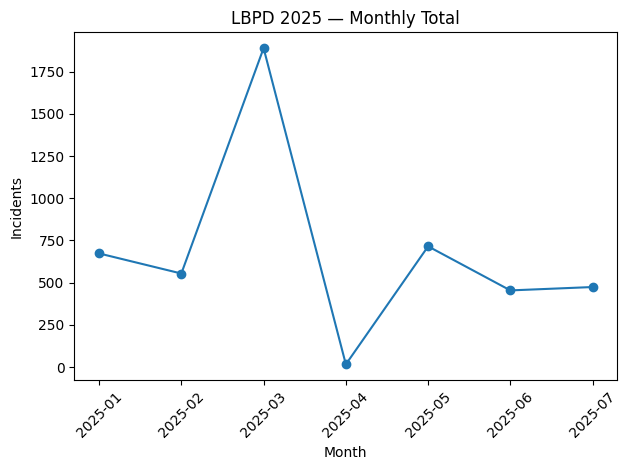

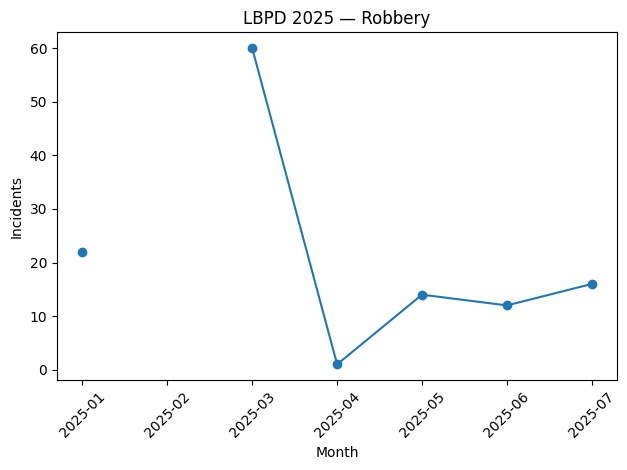

In [ ]:
# Simple visual
import matplotlib.pyplot as plt

# A few headline categories
cats = ["Murder", "Rape / Sexual Assault", "Aggravated Assault", "Robbery", "Burglary", "Auto Burglary", "Petty Theft < $950"]

plot_df = pivoted.copy()
plot_df["label"] = plot_df["year"].astype(str) + "-" + plot_df["month"].astype(str).str.zfill(2)

# Total trend
plt.figure()
plt.plot(plot_df["label"], plot_df["monthly_total"], marker="o")
plt.xticks(rotation=45)
plt.title("LBPD 2025 — Monthly Total")
plt.xlabel("Month"); plt.ylabel("Incidents")
plt.tight_layout()
plt.show()

# One example category trend
cat = "Robbery"
if cat in plot_df.columns:
    plt.figure()
    plt.plot(plot_df["label"], plot_df[cat], marker="o")
    plt.xticks(rotation=45)
    plt.title(f"LBPD 2025 — {cat}")
    plt.xlabel("Month"); plt.ylabel("Incidents")
    plt.tight_layout()
    plt.show()


In [ ]:
# Export for BI tools
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/lbpd_output"
!cp -v /content/data/lbpd_2025_tidy.csv "/content/drive/MyDrive/lbpd_output/"
!cp -v /content/data/lbpd_2025_pivot.csv "/content/drive/MyDrive/lbpd_output/"


Mounted at /content/drive
'/content/data/lbpd_2025_tidy.csv' -> '/content/drive/MyDrive/lbpd_output/lbpd_2025_tidy.csv'
'/content/data/lbpd_2025_pivot.csv' -> '/content/drive/MyDrive/lbpd_output/lbpd_2025_pivot.csv'
